# Road Weather
This is an example of pulling in real-time weather observations across portions of Colorado. It is put in the perspective of what and how a road weather manager might use a weather observations API to better understand road weather conditions, tendencies etc


# 0) Load in libraries, set parameters

In [ ]:
#load necessary libraries
import json #for processing json output
import pandas as pd #for creating a pandas dataframe
import urllib.request as req #for parsing returned json object
import matplotlib.pyplot as plt #for plotting
%matplotlib inline 
from google.colab import data_table #visualize data tables
from datetime import datetime, timedelta #datetime library
data_table.enable_dataframe_formatter #helps make dataframes easier to visualize, sort, etc

#settings and vars
API_TOKEN = 'your_token_here'
variables = 'air_temp,relative_humidity,wind_speed,wind_direction,wind_gust,dew_point_temperature,visibility,road_temp,soil_temp'

#1) create definitions on getting, processing data from API

In [ ]:
def return_station_df(data, service):
    """Build pandas dataframes for data and metadata using json response from 
        requests to Time Series, Nearest, and Latest services

    Parameters:
        data: dict, json response from API request
        service: str, Synoptic web service requested
    
    Returns:
        data_df: pandas DataFrame, data return from all station
        meta_df: pandas DataFrame, station metadata
    """
    dattim_format = '%Y-%m-%d %H:%M'
    meta_list = []
    # We iterate over the list of stations
    for i in range(len(data)):
        # Append station metadata to a grand list that we'll convert to a df
        stid = data[i]['STID']
        mnet_id = data[i]['MNET_ID']
        try:
            lon = float(data[i]['LONGITUDE'])
        except TypeError:
            lon = None
        try:
            lat = float(data[i]['LATITUDE'])
        except TypeError:
            lat = None
        try:
            elev = float(data[i]['ELEVATION'])
        except TypeError:
            elev = None
        meta_list.append([stid, mnet_id, lon, lat, elev])

        # Create a multi-index object to attach to the data df
        data_out = data[i]['OBSERVATIONS'].copy()
        if service == 'timeseries':
            datetime = pd.to_datetime(data_out['date_time'], format=(dattim_format))
            del data_out['date_time']
            multi_index = pd.MultiIndex.from_product([[stid], datetime],
                                                     names=["stid", "dattim"])
        else:
            datetime = pd.to_datetime(data_out[list(data_out.keys())[0]]['date_time'], format=(dattim_format))
            for key in data_out:
                data_out.update({key: data_out[key]['value']})
            multi_index = pd.MultiIndex.from_arrays([[stid], [datetime]],
                                                    names=["stid", "dattim"])

        # Build the data df, concatenating as needed
        if i == 0:
            data_df = pd.DataFrame(data_out, index=multi_index)
        else:
            data_df = pd.concat([data_df, pd.DataFrame(data_out, index=multi_index)], axis=0)

    #Build metadata dataframe from list
    meta_df = pd.DataFrame(meta_list, columns=["stid", "mnet_id", "lon", "lat", "elev"])
    meta_df.set_index('stid', inplace=True)

    # Sort the resulting data dataframe by time
    data_df.sort_index(inplace=True)

    return data_df, meta_df

In [ ]:
def make_api_request(url, api_args):
    """Build the api request from the url and api_args, make the request, and parse 
    the json return to a dictionary

    Parameters:
        url: str, url of the api endpoint
        api_args: dict, api arguments
    
    Returns:
        output: dict, api request response 
    """
    # Append the api arguments on to the url
    for argument, value in api_args.items():
        url = url + '&' + argument + '=' + value

    # Make the api request
    print(f"API request: {url}")
    with req.urlopen(url) as response:
        body = response.read()

    # parse the json response. 
    try:
        output = json.loads(body)
    except:
        decoded_body = body.decode('latin1')
        output = json.loads(decoded_body)

    return output

# 2) Define and make custom API call for latest observations

In [ ]:
#Let's see what real-time observations are available within 20 miles of Denver
# url = 'https://api.synopticdata.com/v2/stations/latest?'
# api_params = {'radius': '34.427,-119.159,20',
#             'within': '90',
#             'token': API_TOKEN,
#             'status': 'active',
#             'units' : 'english,speed|mph',
#             'vars': variables}


# Or we can look at observations around Snoqualmie Pass, WA
url = 'https://api.synopticdata.com/v2/stations/latest?'
api_params = {'radius': '47.427,-121.418,40',
            'within': '90',
            'token': API_TOKEN,
            'status': 'active',
            'units' : 'english,speed|mph',
            'vars': variables}

In [ ]:
#call api request definition with API arguments/parameters
data = make_api_request(url, api_params)

API request: https://api.synopticdata.com/v2/stations/latest?&radius=47.427,-121.418,40&within=90&token=2ab1663fb2fb475ca05da603f5eb94ed&status=active&units=english,speed|mph&vars=air_temp,relative_humidity,wind_speed,wind_direction,wind_gust,dew_point_temperature,visibility,road_temp,soil_temp


**Try it yourself**

We got back a JSON object which Python stores as a dictionary. The different classes of the JSON object are represented as keys of the dictonary. 

How many keys are there? 

How many stations did we get returned?

Where are the actual observed values?

What units are wind speed, and gust, is it indeed in english units?

In [ ]:
#list out keys of the 'data' dictionary, there are a couple ways to do this


In [ ]:
#print specific keys of the dictionary to understand its contents

In [ ]:
#now call definition converting dictionary to pandas dataframe, notice we get two dataframes back
data_df, meta_df = return_station_df(data['STATION'], 'latest')

**Try it yourself**

We now have our observations and metadata keys in dataframes. Look at summaries (i.e. head(df) or df.info()) of dataframes

Are the number of rows the same as the number of stations?

How does pandas handle the datatype for numerical values?

What does that tell us about working with many observations (stations or times)?


In [ ]:
#look at at the data_df dataframe

In [ ]:
# look at the meta_df dataframe

In [ ]:
#Let's combine data frames
#Helpful to make dattim a column 
data_df = data_df.reset_index(level=['dattim'])

#I would like my observederge for one dataframe
data_meta_df = pd.merge(meta_df, data_df,how='left', on='stid')

# 3) Now let's explore the data


In [ ]:
#Interested in more metadata and visualizing nearby stations?
#Check out explore tool, default page, or add in STID in https://explore.synopticdata.com/TSUNS/metadata

In [ ]:
#let's look at the dataframe enabling the Collab data table viewer (click the marker w/ stars icon)
data_meta_df 

,mnet_id,lon,lat,elev,dattim,dew_point_temperature_value_1d,visibility_value_1,wind_direction_value_1,air_temp_value_1,wind_speed_value_1,relative_humidity_value_1,dew_point_temperature_value_1,wind_gust_value_1,road_temp_value_1,road_temp_value_3,road_temp_value_2,soil_temp_value_1,soil_temp_value_2
stid,,,,,,,,,,,,,,,,,,
KRNT,1,-122.214370,47.495090,23.0,2023-01-08 03:53:00+00:00,40.95,10.00,0.0,46.04,0.0,82.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KSMP,1,-121.338170,47.276480,3970.0,2023-01-08 03:56:00+00:00,29.91,0.25,0.0,37.04,0.0,75.48,30.02,NaN,NaN,NaN,NaN,NaN,NaN
GWFW1,2,-121.595556,47.115556,2405.0,2023-01-08 04:00:00+00:00,30.96,NaN,97.0,42.00,17.0,65.00,NaN,28.0,NaN,NaN,NaN,NaN,NaN
SKKW1,2,-121.286000,47.799917,2028.0,2023-01-08 03:29:00+00:00,31.64,NaN,322.0,37.00,2.0,81.00,NaN,8.0,NaN,NaN,NaN,NaN,NaN
LSFW1,2,-121.489722,47.210000,1637.0,2023-01-08 03:29:00+00:00,33.28,NaN,91.0,39.00,2.0,80.00,NaN,11.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G1372,65,-122.116670,47.600000,295.0,2023-01-08 04:00:00+00:00,43.92,NaN,NaN,45.00,0.0,96.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN
G1700,65,-122.066000,47.372330,620.0,2023-01-08 04:00:00+00:00,35.33,NaN,108.0,47.00,3.0,64.00,NaN,10.0,NaN,NaN,NaN,NaN,NaN
G1943,65,-122.192830,47.545500,236.0,2023-01-08 04:00:00+00:00,41.92,NaN,NaN,43.00,0.0,96.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN


**We have our data in a dataframe, let's do some exploration of the data**


In [ ]:
data_df

,dattim,dew_point_temperature_value_1d,visibility_value_1,wind_direction_value_1,air_temp_value_1,wind_speed_value_1,relative_humidity_value_1,dew_point_temperature_value_1,wind_gust_value_1,road_temp_value_1,road_temp_value_3,road_temp_value_2,soil_temp_value_1,soil_temp_value_2
stid,,,,,,,,,,,,,,
A1381,2023-01-08 03:00:00+00:00,NaN,NaN,69.6,44.42,6.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP31,2023-01-08 03:00:00+00:00,32.47,NaN,NaN,32.78,NaN,98.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP55,2023-01-08 03:00:00+00:00,25.36,NaN,88.0,26.70,0.08,94.7,NaN,0.70,NaN,NaN,NaN,NaN,NaN
AMRW1,2023-01-08 03:30:00+00:00,NaN,NaN,NaN,33.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AN625,2023-01-08 03:00:00+00:00,NaN,NaN,NaN,49.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSR18,2023-01-08 04:00:00+00:00,33.26,1.24,111.0,48.38,4.35,56.0,NaN,13.67,46.04,NaN,NaN,NaN,NaN
TSUNS,2023-01-08 04:05:00+00:00,41.25,1.24,50.0,43.16,0.62,93.0,NaN,3.11,63.68,NaN,NaN,NaN,NaN
TTANN,2023-01-08 04:00:00+00:00,34.30,1.24,75.0,48.56,13.67,58.0,NaN,21.75,45.86,NaN,NaN,NaN,NaN


**Try it yourself**

How many stations actually have road temperature?

What is the correlation of road temperature to elevation? Does it match what we would expect?

Text(0, 0.5, 'Road Temperature (Fahrenheit)')

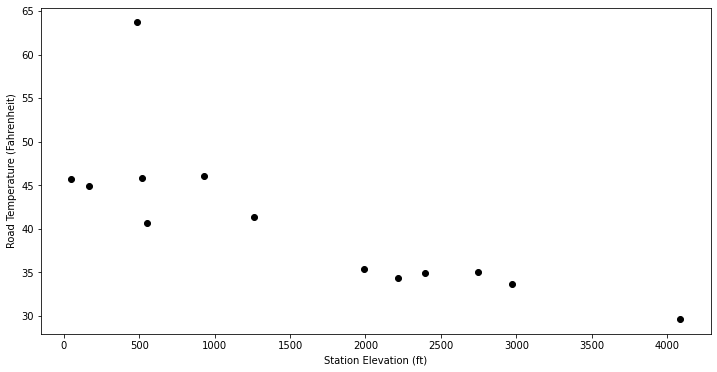

In [23]:
#Let's plot road temperature vs elevation
road_elev = pd.concat([road_temp, meta_df['elev']], axis=1)
fig0 = plt.figure(0, figsize=(12,6))
ax0 = fig0.add_subplot(111)
ax0.plot(road_elev['elev'], road_elev['road_temp_value_1'], 'ko')
ax0.set_xlabel("Station Elevation (ft)")
ax0.set_ylabel(f"Road Temperature ({data['UNITS']['road_temp']})")


**Try it yourself**

Which of these stations is a noticeable outlier?

We can look at more metadata on this station by visiting https://explore.synopticdata.com/${STID}/metadata. Does anything stand out?



# 4) Which stations are near or below freezing?

Let's say we're really concerned about road temperatures and how to prepare resources, supplies for an approaching winter storm. Where might icing be an issue and warrant more road treatment?



In [24]:
data_meta_df[(data_meta_df['road_temp_value_1']<35.0)]

,mnet_id,lon,lat,elev,dattim,dew_point_temperature_value_1d,visibility_value_1,wind_direction_value_1,air_temp_value_1,wind_speed_value_1,relative_humidity_value_1,dew_point_temperature_value_1,wind_gust_value_1,road_temp_value_1,road_temp_value_3,road_temp_value_2,soil_temp_value_1,soil_temp_value_2
stid,,,,,,,,,,,,,,,,,,
TELKH,36,-120.78600,47.11300,2217.0,2023-01-08 04:06:00+00:00,33.19,0.19,150.0,33.44,0.62,99.0,NaN,1.24,34.34,32.72,NaN,NaN,NaN
TALPE,36,-121.41800,47.42700,2972.0,2023-01-08 04:02:00+00:00,32.76,1.24,25.0,33.26,2.49,98.0,NaN,8.70,33.62,NaN,33.08,NaN,NaN
TPRIC,36,-121.30692,47.30531,2395.0,2023-01-08 04:03:00+00:00,33.13,1.24,90.0,34.70,4.97,94.0,NaN,9.94,34.88,NaN,109.58,NaN,NaN
TBLEW,36,-120.57710,47.33480,4085.0,2023-01-08 03:40:00+00:00,-23.03,NaN,NaN,28.58,0.00,9.0,NaN,6.84,29.66,NaN,NaN,NaN,NaN


Let's get the past 48 hours of the these stations, print out a list of stations below 35F and put them into the url below for our time series API request

In [ ]:
data_meta_df[(data_meta_df['road_temp_value_1']<35.0)].index.tolist()

['TELKH', 'TFRAN', 'TALPE', 'TPRIC', 'TBULL', 'TABRN']

In [25]:
#now get a timeseries of data for a select list of station
end = datetime.strftime(datetime.utcnow(), '%Y%m%d%H%M')
start = datetime.strftime(datetime.utcnow() - timedelta(2), '%Y%m%d%H%M')

url = 'https://api.synopticdata.com/v2/stations/timeseries?'
api_args = {'stid': 'TELKH,TFRAN,TALPE,TPRIC,TBULL,TABRN',
            'start': start,
            'end': end,
            'token': API_TOKEN,
            'status': 'active',
            'units' : 'english,speed|mph',
            'vars': variables}



In [32]:
#clear out data vars to be safe
if 'data' in globals():
    del data
if 'data_df' in globals():
    del data_df
if 'meta_df' in globals():
    del meta_df
if 'data_meta_df' in globals():
    del data_meta_df

data = make_api_request(url, api_args)
data_df, meta_df = return_station_df(data['STATION'], 'timeseries')

#Merge for one dataframe
data_meta_df = pd.merge(meta_df, data_df,how='left', on='stid')


API request: https://api.synopticdata.com/v2/stations/timeseries?&stid=TELKH,TFRAN,TALPE,TPRIC,TBULL,TABRN&start=202301060445&end=202301080445&token=2ab1663fb2fb475ca05da603f5eb94ed&status=active&units=english,speed|mph&vars=air_temp,relative_humidity,wind_speed,wind_direction,wind_gust,dew_point_temperature,visibility,road_temp,soil_temp


In [38]:
meta_df

,mnet_id,lon,lat,elev
stid,,,,
TELKH,36,-120.78600,47.11300,2217.0
TFRAN,36,-121.43200,47.42600,2746.0
TALPE,36,-121.41800,47.42700,2972.0
TPRIC,36,-121.30692,47.30531,2395.0
TBULL,36,-121.03130,47.18210,1989.0
TABRN,36,-122.23290,47.30350,89.0


Text(0, 0.5, 'Road Temp (Fahrenheit)')

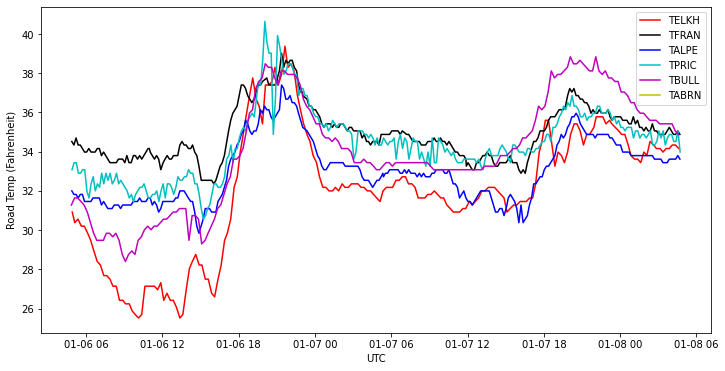

In [42]:
#plot the time series of road temperature for each station currently below 35F
fig1 = plt.figure(1, figsize=(12,6))
ax = fig1.add_subplot(111)
ax.plot(data_df.loc['TELKH'].index, data_df.loc['TELKH','road_temp_set_1'], 'r-', label='TELKH')
ax.plot(data_df.loc['TFRAN'].index, data_df.loc['TFRAN','road_temp_set_1'], 'k-', label='TFRAN')
ax.plot(data_df.loc['TALPE'].index, data_df.loc['TALPE','road_temp_set_1'], 'b-', label='TALPE')
ax.plot(data_df.loc['TPRIC'].index, data_df.loc['TPRIC','road_temp_set_1'], 'c-', label='TPRIC')
ax.plot(data_df.loc['TBULL'].index, data_df.loc['TBULL','road_temp_set_1'], 'm-', label='TBULL')
ax.plot(data_df.loc['TABRN'].index, data_df.loc['TABRN','road_temp_set_1'], 'y-', label='TABRN')
ax.legend()
ax.set_xlabel('UTC')
ax.set_ylabel(f"Road Temp ({data['UNITS']['road_temp']})")